<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/Detec%C3%A7%C3%A3o_Histopatol%C3%B3gica_de_C%C3%A2ncer_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Detecção Histopatológica de Câncer - Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

[PatchCamelyon (PCam) Dataset](https://github.com/basveeling/pcam)

## Importação de Bibliotecas e Download dos Dados

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(42)  #torna os números aleatórios gerados previsíveis, de modo a ter consistência entre execuções. 42 escolhido arbitrariamente.

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os
import cv2

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)  #torna os números aleatórios gerados previsíveis, de modo a ter consistência entre execuções. 42 escolhido arbitrariamente.


# Define algumas constantes
TAMANHO_IMAGEM = 96
CANAIS_IMAGEM = 3
TAMANHO_AMOSTRA = 10000

DATASET_PATH = "/content/dataset/"

sns.set_theme(style='white', palette='deep')

>Os códigos da célula abaixo são necessários para o download do dataset do Kaggle. Para a correta execução, é necessário que seja gerado o arquivo ```kaggle.json```, que contém a autorização para uso da API. Mais informações podem ser obtidas na documentação da [API do Kaggle](https://www.kaggle.com/docs/api).

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle # Instala uma versão mais recente da API do que a padrão do Colab

!mkdir -p ~/.kaggle # Cria o diretório para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Muda as permissões do arquivo
!cp kaggle.json ~/.kaggle/  # Copia o arquivo kaggle.json para o diretório recém criado
#!ls ~/.kaggle

!kaggle competitions download -c histopathologic-cancer-detection -p {DATASET_PATH} # download do arquivo .zip para o diretório informado

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=4b8c6a03a65678fbe1e43ef6332d0216592775d07f1e25df4f96ddf83262e6b6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
kaggle.json
100% 6.31G/6.31G [01:32<00:00, 65.1MB/s]
100% 6.31G/6.31G [01:32<00:00, 72.9MB/s]


In [ ]:
!unzip -q {DATASET_PATH}histopathologic-cancer-detection.zip -d {DATASET_PATH}  # unzipa o arquivo

## Criação de DataFrames

> O arquivo ```train_labels.csv``` contém o nome das imagens (armazenadas em duas pastas distintas, uma para treino e outra para teste) e o seu respectivo label.

In [ ]:
df_data = pd.read_csv(f'{DATASET_PATH}train_labels.csv')  # Cria um DataFrame
print(df_data.shape)  # Formato do dataframe (Linhas, Colunas)
df_data.head(3) # Imprime as 3 primeiras Linhas

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [ ]:
print("Quantidade de Amostras de Treino:", len(os.listdir('/content/dataset/train')))
print("Quantidade de Amostras de Teste:", len(os.listdir('/content/dataset/test')))

Quantidade de Amostras de Treino: 220025
Quantidade de Amostras de Teste: 57458


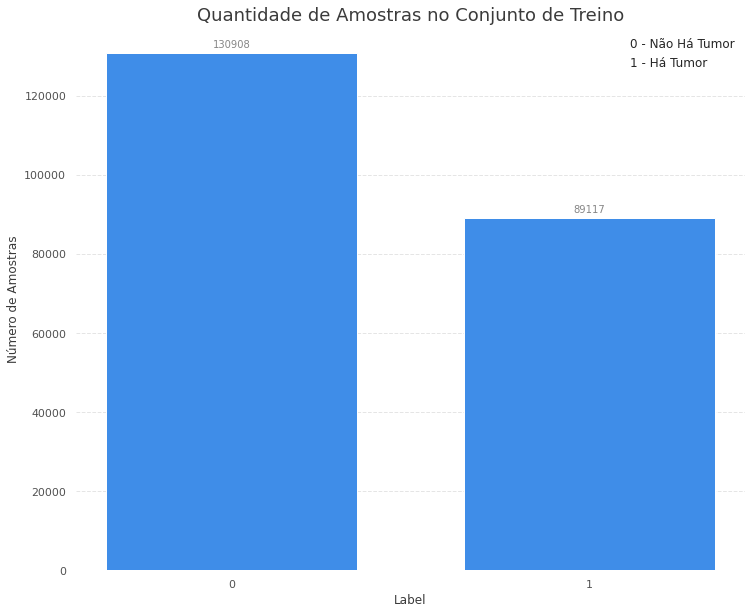

In [ ]:
### Um plot para visualização da distribuição de amostras para cada um dos labels

count_label = df_data['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Quantidade de Amostras no Conjunto de Treino", size=18, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
plt.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',
           prop={'size':12},
           )

plt.show();

In [ ]:
# Cria o dataframe com as imagens de fato. Será garantido que ambos os labels contenham igual número de amostras.

df_0 = df_data[df_data['label'] == 0].sample(TAMANHO_AMOSTRA, random_state = 42)    # Apenas imagens com label 0
df_1 = df_data[df_data['label'] == 1].sample(TAMANHO_AMOSTRA, random_state = 42)    # Apenas imagens com label 1

# Concatena ambos os dataframes e realiza um shuffle das linhas
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

### Visualização de Amostras de Imagens

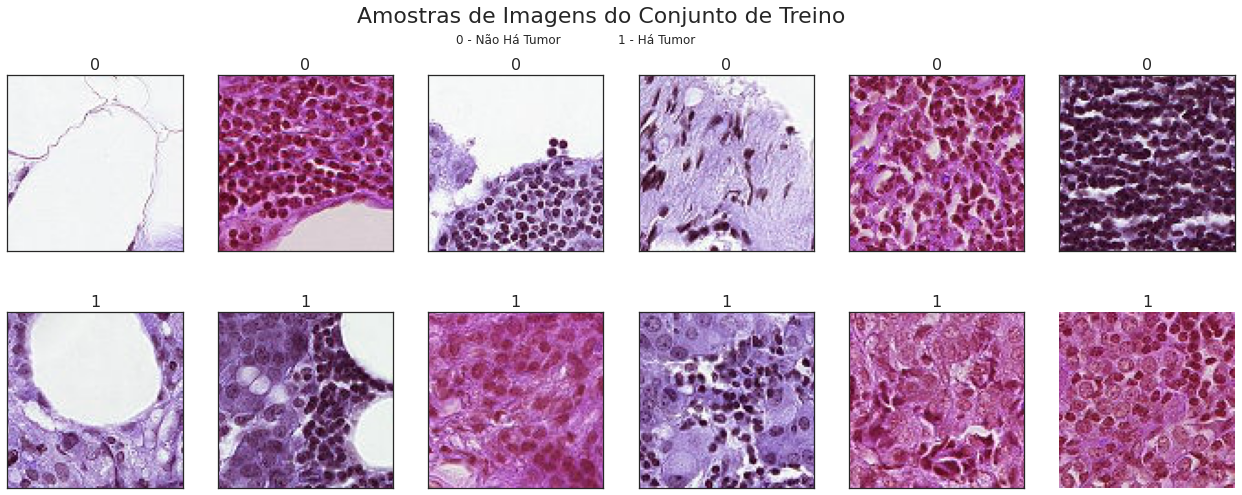

In [ ]:
col_name = 'label'
figure_cols = 6
df = df_data
IMAGE_PATH = '/content/dataset/train/' 

categories = (df.groupby([col_name])[col_name].nunique()).index
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

for i, cat in enumerate(categories):
    sample = df[df[col_name]==cat].sample(figure_cols)

    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
        im=cv2.imread(file)
        ax[i, j].imshow(im, resample=True, cmap='gray')
        ax[i, j].set_title(cat, fontsize=16)  
        ax[i, j].grid(False)
        plt.box(False)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',
           prop={'size':12},
           ncol=2,
           bbox_to_anchor=(0.26, .76, 1, 1), #(x, y, width, height)
           loc=3,  
           )
f.suptitle("Amostras de Imagens do Conjunto de Treino", size=22, y=0.98)
plt.savefig("Amostra-Treino.png", bbox_inches='tight', dpi=100)
plt.show()